In [2]:
import os, sys
import numpy as np
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, top_k_accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import preprocessor as p
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.dataset import load_dataset
from src.model.BiLSTMClassifier import EnhancedBiLSTM
from src.embedding_matrix import *

In [3]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA H100 PCIe


# BiLTSM Model
- On GloVe Twitter Embeddings(100d)
- On FastText Crawl Subwords Embeddings(300d)

In [4]:
train, _, _, _ = load_dataset()

X = train["TEXT"].values.astype("U")
y = train["Label"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
vocab = create_vocab()

glove_embeddings = load_pretrained_embeddings("glove-twitter-100")
create_embedding_matrix_glove(vocab, glove_embeddings)

glove_embeddings_200d = load_pretrained_embeddings("glove-twitter-200")
create_embedding_matrix_glove(vocab, glove_embeddings_200d)

fasttext_embeddings = load_fasttext()
create_embedding_matrix_fasttext(vocab, fasttext_embeddings)

KeyboardInterrupt: 

In [6]:
def top_k_accuracy(predict):
    y_scores = np.zeros((len(X_test), 20))
    top_k_accs = {}

    for i, (_, scores) in enumerate(predict):
        for label, score in scores.items():
            y_scores[i, label] = score

    for k in [1, 3, 5]:
        acc = top_k_accuracy_score(y_test, y_scores, k=k)
        top_k_accs[f"top_{k}_accuracy"] = acc

    return top_k_accs

## GloVe Twitter Embeddings(100d)

In [7]:
embedding_matrix_glove = np.load("../data/embeddings/embedding_matrix_glove_twitter_100.npy")
vocab = np.load("../data/embeddings/vocab.npy", allow_pickle=True).item()

vocab_size, embedding_dim_glove = embedding_matrix_glove.shape
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 45397


In [8]:
tokenizer = TweetTokenizer()

def encode(text, vocab, max_len=50):
    text = p.tokenize(text)
    tokens = tokenizer.tokenize(text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

max_len = 50

X_train_ids_glove = np.array([encode(t, vocab, max_len) for t in X_train])
X_test_ids_glove  = np.array([encode(t, vocab, max_len) for t in X_test])

In [9]:

batch_size = 64
num_classes = len(np.unique(y_train))

train_dataset_glove = TensorDataset(
    torch.tensor(X_train_ids_glove, dtype=torch.long).to(device),
    torch.tensor(y_train, dtype=torch.long).to(device)
)
train_loader_glove = DataLoader(train_dataset_glove, batch_size=batch_size, shuffle=True)

model_glove = EnhancedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_glove,
    hidden_dim=256,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_glove,
    freeze_embeddings=True,
    num_layers=2,
    dropout=0.5
)

optimizer = optim.Adam(model_glove.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [10]:
model_glove.to(device)

train_losses_glove = []
val_losses_glove = []
epochs = 20

for epoch in range(epochs):
    model_glove.train()
    total_loss = 0
    total = 0

    for x_batch, y_batch in train_loader_glove:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model_glove(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_batch.size(0)
        total += x_batch.size(0)

    # Save the model
    torch.save(model_glove.state_dict(), f"models/bilstm_glove_twitter_{epoch+1}_epochs.pth")

    # Validation
    model_glove.eval()
    with torch.no_grad():
        X = torch.tensor(X_test_ids_glove, dtype=torch.long).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
        
        logits = model_glove(X)
        pred = logits.argmax(dim=1)
        accuracy = (pred == y_test_tensor).float().mean().item()
        val_loss = criterion(logits, y_test_tensor).item()

    train_losses_glove.append(total_loss / total)
    val_losses_glove.append(val_loss)

    print(f"Epoch {epoch+1}, "
          f"Training Loss={total_loss / total:.4f}, "
          f"Validation Loss={val_loss:.4f}, "
          f"Validation Accuracy={accuracy:.4f}")

Epoch 1, Training Loss=2.5378, Validation Loss=2.3299, Validation Accuracy=0.3059
Epoch 2, Training Loss=2.3895, Validation Loss=2.2690, Validation Accuracy=0.3209
Epoch 3, Training Loss=2.3401, Validation Loss=2.2371, Validation Accuracy=0.3360
Epoch 4, Training Loss=2.2989, Validation Loss=2.2137, Validation Accuracy=0.3361
Epoch 5, Training Loss=2.2735, Validation Loss=2.1994, Validation Accuracy=0.3400
Epoch 6, Training Loss=2.2492, Validation Loss=2.1894, Validation Accuracy=0.3439
Epoch 7, Training Loss=2.2293, Validation Loss=2.1697, Validation Accuracy=0.3494
Epoch 8, Training Loss=2.2079, Validation Loss=2.1725, Validation Accuracy=0.3494
Epoch 9, Training Loss=2.1900, Validation Loss=2.1590, Validation Accuracy=0.3532
Epoch 10, Training Loss=2.1742, Validation Loss=2.1517, Validation Accuracy=0.3560
Epoch 11, Training Loss=2.1565, Validation Loss=2.1613, Validation Accuracy=0.3538
Epoch 12, Training Loss=2.1393, Validation Loss=2.1563, Validation Accuracy=0.3546
Epoch 13, Tra

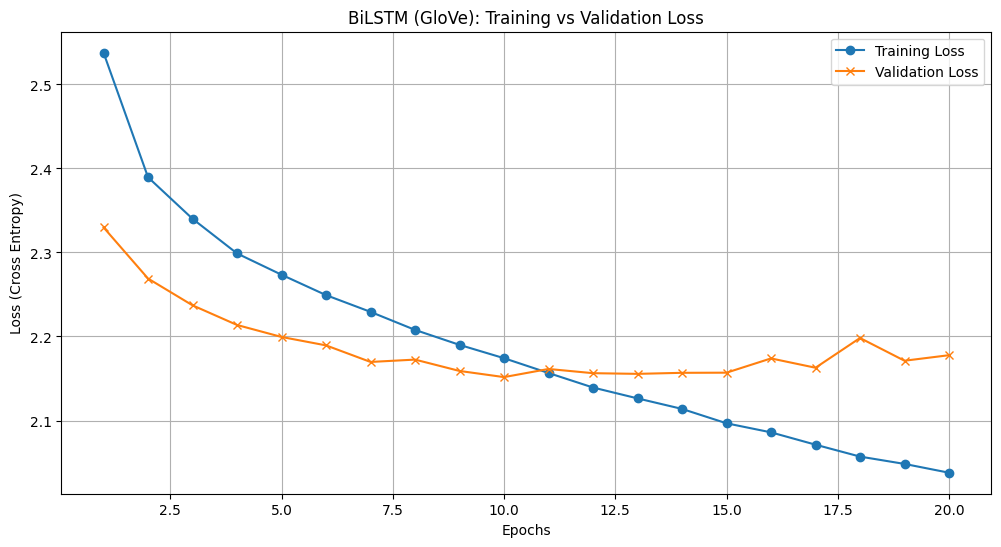

Top-K Accuracies: {'top_1_accuracy': 0.35792857142857143, 'top_3_accuracy': 0.6095, 'top_5_accuracy': 0.7318571428571429}
Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.00      0.01       282
           1       0.41      0.47      0.44       531
           2       0.30      0.20      0.24      1408
           3       0.34      0.59      0.43      1384
           4       0.19      0.02      0.03       372
           5       0.61      0.66      0.63       387
           6       0.41      0.16      0.23       431
           7       0.53      0.44      0.48       875
           8       0.20      0.00      0.01       377
           9       0.33      0.75      0.46      3049
          10       0.20      0.01      0.03       355
          11       0.61      0.43      0.50       509
          12       0.33      0.45      0.38       370
          13       0.34      0.22      0.27       644
          14       0.44      0.05      0.09

/u50/duanx15/anaconda3/envs/4AL3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/u50/duanx15/anaconda3/envs/4AL3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/u50/duanx15/anaconda3/envs/4AL3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses_glove, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses_glove, label='Validation Loss', marker='x')
plt.title('BiLSTM (GloVe): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

plt.show()

model_glove.load_state_dict(torch.load(f"models/bilstm_glove_twitter_best.pth"))

model_glove.eval()
with torch.no_grad():
    X = torch.tensor(X_test_ids_glove, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    logits = model_glove(X)
    pred = logits.argmax(dim=1)
    preds = logits.softmax(dim=1)

    preds = [
        {label: score for label, score in enumerate(sample_scores)}
        for sample_scores in preds
    ]
    top_k_accs = top_k_accuracy(enumerate(preds))
    print("Top-K Accuracies:", top_k_accs)

    report = classification_report(y_test_tensor.cpu().numpy(), pred.cpu().numpy())
    print("Classification Report:\n", report)

    val_loss = criterion(logits, torch.tensor(y_test_tensor, dtype=torch.long)).item()
    print(f"Final Validation Loss: {val_loss:.4f}")


## GloVe Twitter Embeddings(200d)

In [12]:
embedding_matrix_glove_200d = np.load("../data/embeddings/embedding_matrix_glove_twitter_200.npy")
vocab = np.load("../data/embeddings/vocab.npy", allow_pickle=True).item()

vocab_size, embedding_dim_glove_200d = embedding_matrix_glove_200d.shape
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 45397


In [13]:
tokenizer = TweetTokenizer()

def encode(text, vocab, max_len=50):
    text = p.tokenize(text)
    tokens = tokenizer.tokenize(text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

max_len = 50

X_train_ids_glove_200d = np.array([encode(t, vocab, max_len) for t in X_train])
X_test_ids_glove_200d  = np.array([encode(t, vocab, max_len) for t in X_test])

In [29]:

batch_size = 64
num_classes = len(np.unique(y_train))

train_dataset_glove_200d = TensorDataset(
    torch.tensor(X_train_ids_glove_200d, dtype=torch.long).to(device),
    torch.tensor(y_train, dtype=torch.long).to(device)
)
train_loader_glove_200d = DataLoader(train_dataset_glove_200d, batch_size=batch_size, shuffle=True)

model_glove_200d = EnhancedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_glove_200d,
    hidden_dim=256,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_glove_200d,
    freeze_embeddings=True,
    num_layers=2,
    dropout=0.5
)

optimizer = optim.Adam(model_glove_200d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses_glove_200d = []
val_losses_glove_200d = []
epochs = 20

model_glove_200d.to(device)

for epoch in range(epochs):
    model_glove_200d.train()
    total_loss = 0
    total = 0

    for x_batch, y_batch in train_loader_glove_200d:
        optimizer.zero_grad()
        y_pred = model_glove_200d(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        total += x_batch.size(0)

    # Save the model
    torch.save(model_glove_200d.state_dict(), f"models/bilstm_glove_twitter_200d_{epoch+1}_epochs.pth")

    model_glove_200d.eval()
    with torch.no_grad():
        X = torch.tensor(X_test_ids_glove_200d, dtype=torch.long).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
        
        logits = model_glove_200d(X)
        pred = logits.argmax(dim=1)
        accuracy = (pred == y_test_tensor).float().mean().item()
        val_loss = criterion(logits, y_test_tensor).item()

    train_losses_glove_200d.append(total_loss / total)
    val_losses_glove_200d.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss={total_loss / total:.4f}, Validation Loss={val_loss:.4f}, Validation Accuracy={accuracy:.4f}")



Epoch 1, Training Loss=2.4886, Validation Loss=2.2735, Validation Accuracy=0.3289
Epoch 2, Training Loss=2.3296, Validation Loss=2.2285, Validation Accuracy=0.3340
Epoch 3, Training Loss=2.2807, Validation Loss=2.1922, Validation Accuracy=0.3439
Epoch 4, Training Loss=2.2436, Validation Loss=2.1817, Validation Accuracy=0.3489
Epoch 5, Training Loss=2.2114, Validation Loss=2.1676, Validation Accuracy=0.3516
Epoch 6, Training Loss=2.1820, Validation Loss=2.1502, Validation Accuracy=0.3493
Epoch 7, Training Loss=2.1569, Validation Loss=2.1511, Validation Accuracy=0.3550
Epoch 8, Training Loss=2.1384, Validation Loss=2.1410, Validation Accuracy=0.3567
Epoch 9, Training Loss=2.1064, Validation Loss=2.1589, Validation Accuracy=0.3536
Epoch 10, Training Loss=2.0832, Validation Loss=2.1648, Validation Accuracy=0.3467
Epoch 11, Training Loss=2.0583, Validation Loss=2.1739, Validation Accuracy=0.3504
Epoch 12, Training Loss=2.0423, Validation Loss=2.1718, Validation Accuracy=0.3553
Epoch 13, Tra

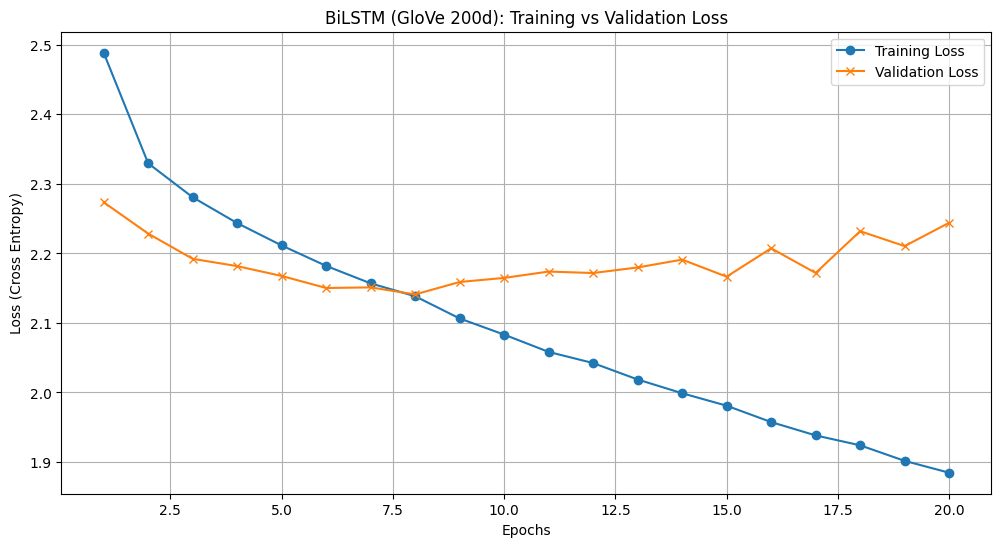

Top-K Accuracies: {'top_1_accuracy': 0.35792857142857143, 'top_3_accuracy': 0.6091428571428571, 'top_5_accuracy': 0.7294285714285714}
Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.02      0.03       282
           1       0.41      0.35      0.38       531
           2       0.32      0.21      0.26      1408
           3       0.36      0.59      0.45      1384
           4       0.11      0.02      0.04       372
           5       0.57      0.72      0.63       387
           6       0.39      0.40      0.39       431
           7       0.46      0.49      0.48       875
           8       0.15      0.06      0.08       377
           9       0.35      0.68      0.46      3049
          10       0.22      0.04      0.06       355
          11       0.59      0.39      0.47       509
          12       0.38      0.40      0.39       370
          13       0.27      0.27      0.27       644
          14       0.38      0.

/tmp/ipykernel_1265097/1110640111.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss = criterion(logits, torch.tensor(y_test_tensor, dtype=torch.long)).item()


In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses_glove_200d, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses_glove_200d, label='Validation Loss', marker='x')
plt.title('BiLSTM (GloVe 200d): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

plt.show()

model_glove_200d.load_state_dict(torch.load(f"models/bilstm_glove_twitter_200d_best.pth"))

model_glove_200d.eval()
with torch.no_grad():
    X = torch.tensor(X_test_ids_glove_200d, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    logits = model_glove_200d(X)
    pred = logits.argmax(dim=1)
    preds = logits.softmax(dim=1)

    preds = [
        {label: score for label, score in enumerate(sample_scores)}
        for sample_scores in preds
    ]
    top_k_accs = top_k_accuracy(enumerate(preds))
    print("Top-K Accuracies:", top_k_accs)

    report = classification_report(y_test_tensor.cpu().numpy(), pred.cpu().numpy())
    print("Classification Report:\n", report)

    val_loss = criterion(logits, torch.tensor(y_test_tensor, dtype=torch.long)).item()
    print(f"Final Validation Loss: {val_loss:.4f}")


## FastText Crawl Subwords Embeddings(300d)

In [21]:
embedding_matrix_fasttext = np.load("../data/embeddings/embedding_matrix_crawl_subword_300.npy")
vocab = np.load("../data/embeddings/vocab.npy", allow_pickle=True).item()

vocab_size, embedding_dim_fasttext = embedding_matrix_fasttext.shape
print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 45397


In [22]:
tokenizer = TweetTokenizer()

def encode(text, vocab, max_len=50):
    text = p.tokenize(text)
    tokens = tokenizer.tokenize(text.lower())
    ids = [vocab.get(t, vocab["<UNK>"]) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [vocab["<PAD>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

max_len = 50

X_train_ids_fasttext = np.array([encode(t, vocab, max_len) for t in X_train])
X_test_ids_fasttext  = np.array([encode(t, vocab, max_len) for t in X_test])

In [23]:

batch_size = 64
num_classes = len(np.unique(y_train))

train_dataset_fasttext = TensorDataset(
    torch.tensor(X_train_ids_fasttext, dtype=torch.long).to(device),
    torch.tensor(y_train, dtype=torch.long).to(device)
)
train_loader_fasttext = DataLoader(train_dataset_fasttext, batch_size=batch_size, shuffle=True)

model_fasttext = EnhancedBiLSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim_fasttext,
    hidden_dim=128,
    num_classes=num_classes,
    embedding_matrix=embedding_matrix_fasttext,
    freeze_embeddings=True,
    num_layers=2,
    dropout=0.5
)

optimizer = optim.Adam(model_fasttext.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [24]:
train_losses_fasttext = []
val_losses_fasttext = []
epochs = 20

model_fasttext.to(device)

for epoch in range(epochs):
    model_fasttext.train()
    total_loss = 0
    total = 0

    for x_batch, y_batch in train_loader_fasttext:
        optimizer.zero_grad()
        y_pred = model_fasttext(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        total += x_batch.size(0)

    # Save the model
    torch.save(model_fasttext.state_dict(), f"models/bilstm_fasttext_{epoch+1}_epoches.pth")

    model_fasttext.eval()
    with torch.no_grad():
        X = torch.tensor(X_test_ids_fasttext, dtype=torch.long).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
        
        logits = model_fasttext(X)
        pred = logits.argmax(dim=1)
        accuracy = (pred == y_test_tensor).float().mean().item()
        val_loss = criterion(logits, y_test_tensor).item()

    train_losses_fasttext.append(total_loss / total)
    val_losses_fasttext.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss={total_loss / total:.4f}, Validation Loss={val_loss:.4f}, Validation Accuracy={accuracy:.4f}")



Epoch 1, Training Loss=2.6436, Validation Loss=2.4399, Validation Accuracy=0.2829
Epoch 2, Training Loss=2.4277, Validation Loss=2.3149, Validation Accuracy=0.3116
Epoch 3, Training Loss=2.3547, Validation Loss=2.2739, Validation Accuracy=0.3210
Epoch 4, Training Loss=2.3173, Validation Loss=2.2433, Validation Accuracy=0.3293
Epoch 5, Training Loss=2.2966, Validation Loss=2.2153, Validation Accuracy=0.3384
Epoch 6, Training Loss=2.2782, Validation Loss=2.2121, Validation Accuracy=0.3358
Epoch 7, Training Loss=2.2614, Validation Loss=2.2024, Validation Accuracy=0.3427
Epoch 8, Training Loss=2.2482, Validation Loss=2.1815, Validation Accuracy=0.3471
Epoch 9, Training Loss=2.2319, Validation Loss=2.1769, Validation Accuracy=0.3501
Epoch 10, Training Loss=2.2195, Validation Loss=2.1773, Validation Accuracy=0.3489
Epoch 11, Training Loss=2.2077, Validation Loss=2.1707, Validation Accuracy=0.3486
Epoch 12, Training Loss=2.1917, Validation Loss=2.1660, Validation Accuracy=0.3504
Epoch 13, Tra

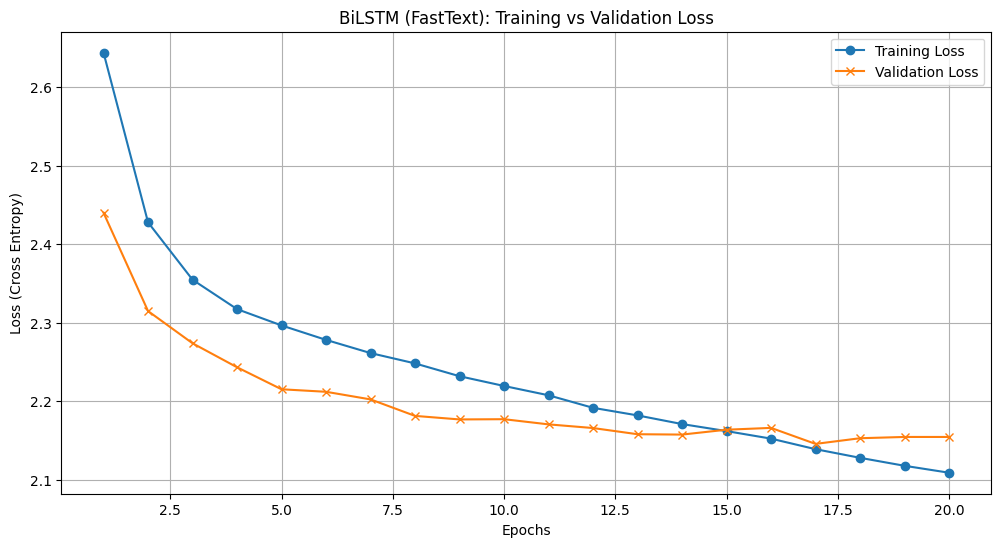

Top-K Accuracies: {'top_1_accuracy': 0.35992857142857143, 'top_3_accuracy': 0.6062857142857143, 'top_5_accuracy': 0.7300714285714286}
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       282
           1       0.39      0.55      0.45       531
           2       0.30      0.25      0.27      1408
           3       0.38      0.53      0.44      1384
           4       0.40      0.02      0.03       372
           5       0.57      0.66      0.62       387
           6       0.47      0.16      0.24       431
           7       0.50      0.46      0.48       875
           8       0.22      0.03      0.05       377
           9       0.33      0.76      0.46      3049
          10       0.17      0.01      0.02       355
          11       0.62      0.38      0.47       509
          12       0.40      0.38      0.39       370
          13       0.35      0.22      0.27       644
          14       0.41      0.

/u50/duanx15/anaconda3/envs/4AL3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/u50/duanx15/anaconda3/envs/4AL3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/u50/duanx15/anaconda3/envs/4AL3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs+1), train_losses_fasttext, label='Training Loss', marker='o')
plt.plot(range(1, epochs+1), val_losses_fasttext, label='Validation Loss', marker='x')
plt.title('BiLSTM (FastText): Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.grid(True)

plt.show()

model_fasttext.load_state_dict(torch.load(f"models/bilstm_fasttext_best.pth"))

model_fasttext.eval()
with torch.no_grad():
    X = torch.tensor(X_test_ids_fasttext, dtype=torch.long).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    
    logits = model_fasttext(X)
    pred = logits.argmax(dim=1)
    preds = logits.softmax(dim=1)

    preds = [
        {label: score for label, score in enumerate(sample_scores)}
        for sample_scores in preds
    ]
    top_k_accs = top_k_accuracy(enumerate(preds))
    print("Top-K Accuracies:", top_k_accs)

    report = classification_report(y_test_tensor.cpu().numpy(), pred.cpu().numpy())
    print("Classification Report:\n", report)

    val_loss = criterion(logits, torch.tensor(y_test_tensor, dtype=torch.long)).item()
    print(f"Final Validation Loss: {val_loss:.4f}")
